In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import pandas as pd

import niskine
import mplniw.plot as pl
import gvpy as gv
import mplniw.sigp as sp
import mplniw.utils as ut

In [2]:
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
root_dir = '/Users/zcasparcohen/codes/NIW/'
figdir = '/Users/zcasparcohen/Documents/NISKINE/Figures/'

In [3]:
mooring=1
wind_work = xr.open_dataset(root_dir+'data/wind_work/ni_wind_work_niskine_m1.nc')
wind_stress = xr.open_dataset(root_dir+'data/wind_work/wind_stress_niskine_m1.nc')
ds = xr.open_dataset(root_dir+'data/M%s_bpfiltered.nc'%mooring)
gridded=xr.open_dataset(root_dir+'data/M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
wkb = niskine.clim.get_wkb_factors(gridded)

In [4]:
mld_m1 = xr.open_dataarray(conf.data.ml.mld).sel(time=slice(ds.time[0],ds.time[-1]))
ds['mld'] = mld_m1
ds['bp_eke'] = ds.bp_eke.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['bpu_wkb'] = ds.bpu_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['bpv_wkb'] = ds.bpv_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['u_filtered'] = ds.u_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['v_filtered'] = ds.v_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)

In [5]:
ds['bpuz'] = wkb*ds['u_filtered'].differentiate('z')
ds['bpvz'] = wkb*ds['v_filtered'].differentiate('z')

#ds['uz'] = wkb*ds['u'].differentiate('z')
#ds['vz'] = wkb*ds['v'].differentiate('z')

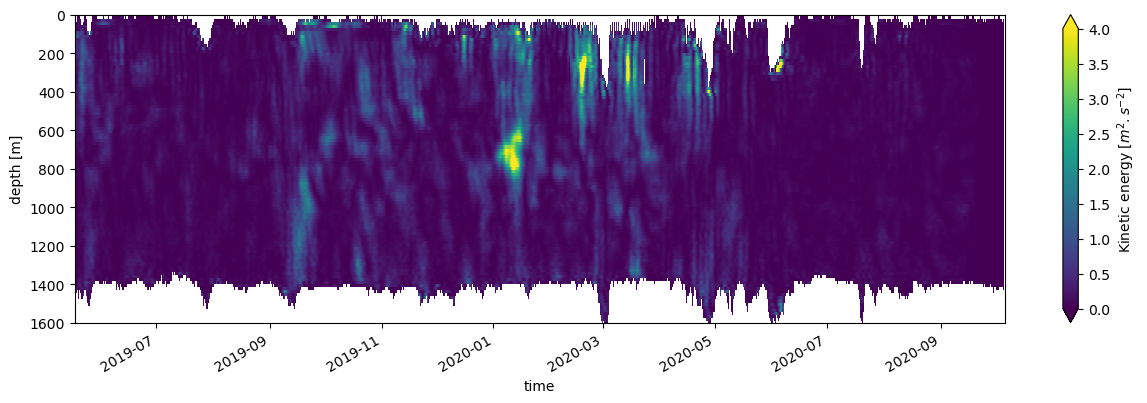

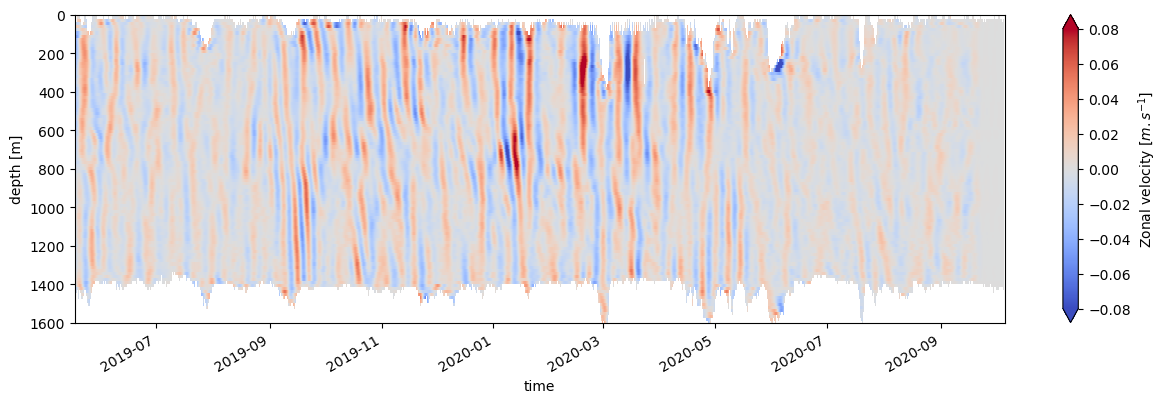

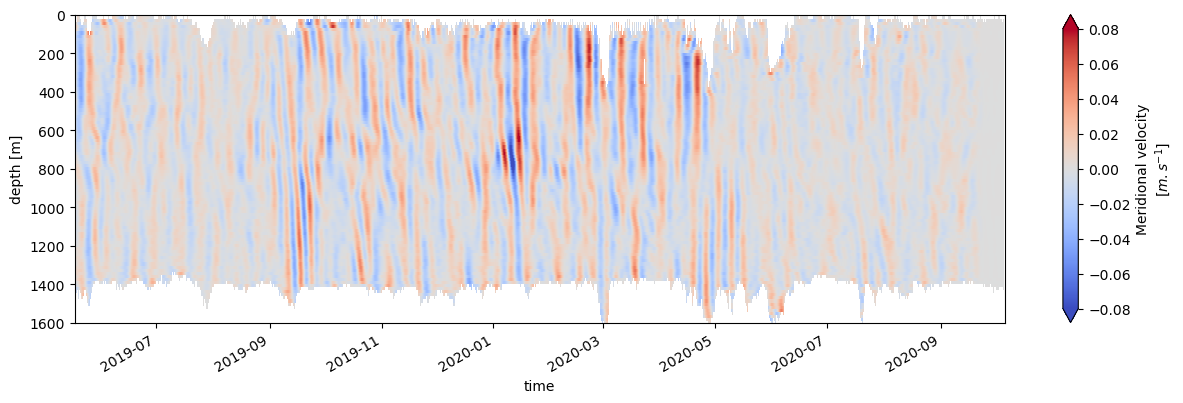

In [6]:
plt.figure(figsize=(15,4))
ds.bp_eke.plot(yincrease=False,ylim=(1600,0),cmap='viridis',vmax=4,vmin=0)
plt.figure(figsize=(15,4))
ds.bpu_wkb.plot(yincrease=False,ylim=(1600,0),cmap='coolwarm',vmax=0.08)
plt.figure(figsize=(15,4))
ds.bpv_wkb.plot(yincrease=False,ylim=(1600,0),cmap='coolwarm',vmax=0.08)

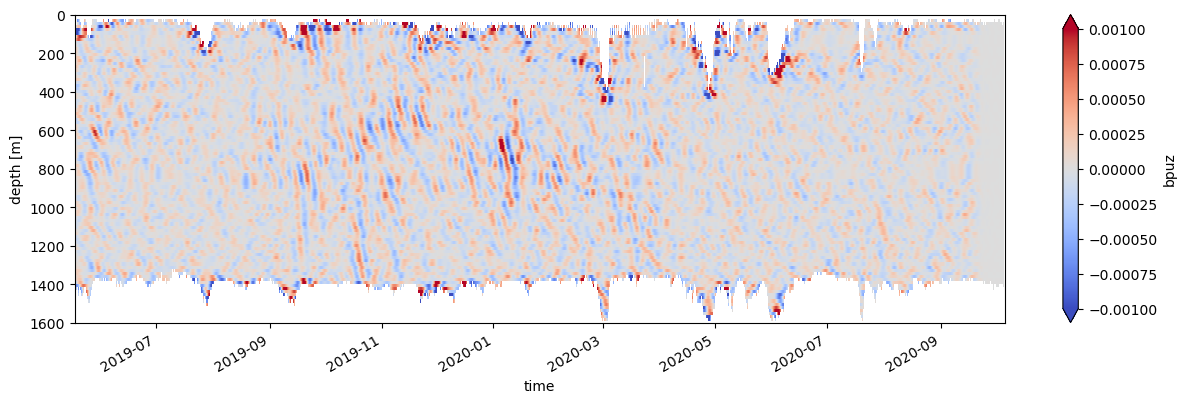

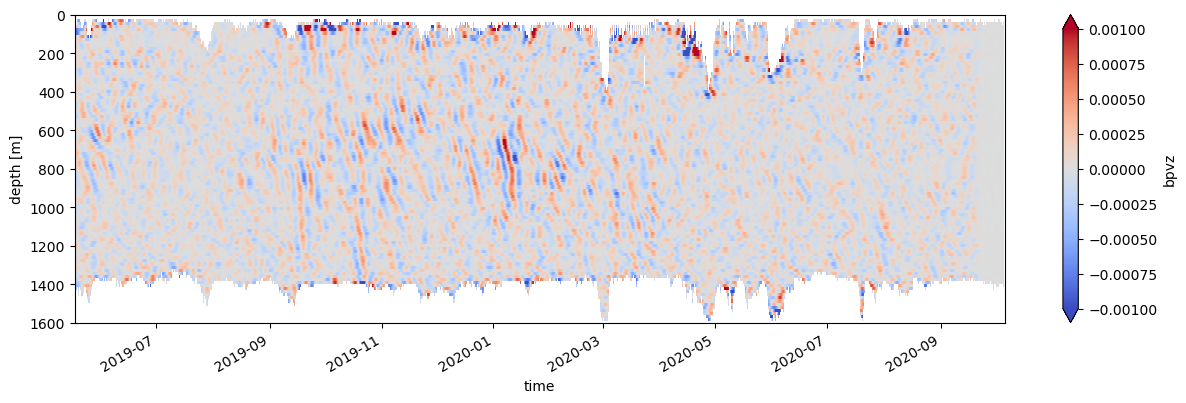

In [7]:
plt.figure(figsize=(15,4))
ds.bpuz.plot(yincrease=False,ylim=(1600,0),cmap='coolwarm',vmax=0.001)
plt.figure(figsize=(15,4))
ds.bpvz.plot(yincrease=False,ylim=(1600,0),cmap='coolwarm',vmax=0.001)

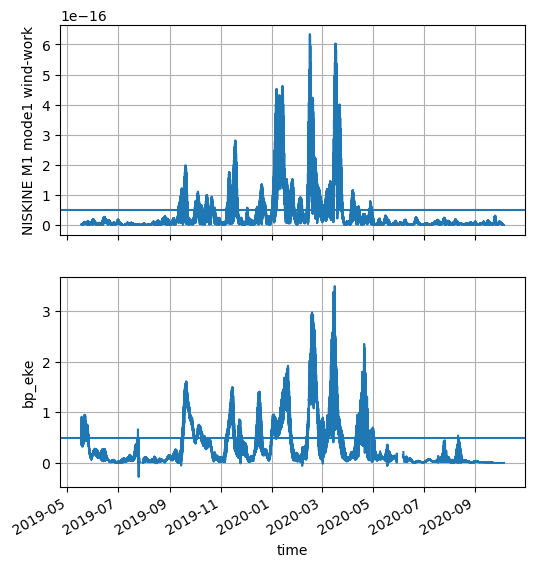

In [8]:
fig,axs = plt.subplots(2,1,figsize=(6,6),sharex=True)
np.abs(wind_work['NISKINE M1 mode1 wind-work']).cumsum().differentiate('time').plot(ax=axs[0])
axs[0].axhline(0.5e-16)
ds.bp_eke.where(ds.z<ds.mld+100).mean('z').plot(ax=axs[1])
axs[1].axhline(0.5)
for ax in axs:
    ax.grid();ax.set_title('')

In [9]:
ds['KE_mld'] = ds.bp_eke.where(ds.z<ds.mld+100).mean('z')
ds['wind_work_diff'] = np.abs(wind_work['NISKINE M1 mode1 wind-work']).cumsum().differentiate('time')

In [10]:
events = ds.where((ds.KE_mld>0.5)&(ds.wind_work_diff>0.5e-16),drop=True)

In [11]:
max_days = 15
t_start = events.time.where((events.time.diff('time')*1e-9/3600).astype('int32')>24*max_days,drop=True)
t_start = xr.concat([events.time[0],t_start],dim='time')
t_start = t_start[:-1]
t_end = events.time.roll(time=1).where((events.time.diff('time')*1e-9/3600).astype('int32')>24*max_days,drop=True)


In [12]:
print(t_start,t_end)

<xarray.DataArray 'time' (time: 4)>
array(['2019-09-15T23:00:00.000000000', '2019-11-07T19:00:00.000000000',
       '2019-12-13T16:00:00.000000000', '2020-02-12T11:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-09-15T23:00:00 ... 2020-02-12T11:00:00
    lat      float64 59.1
    lon      float64 -21.2
    mode     int64 1
Attributes:
    long_name:    <xarray.DataArray 'time' (time: 4)>
array(['2019-10-09T23:00:00.000000000', '2019-11-21T02:00:00.000000000',
       '2020-01-24T19:00:00.000000000', '2020-03-24T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-11-07T19:00:00 ... 2020-04-13T10:00:00
    lat      float64 59.1
    lon      float64 -21.2
    mode     int64 1
Attributes:
    long_name:   


In [13]:
for ti,tf in zip(t_start,t_end):
    _ = ds.sel(time=slice(ti,tf))
    print(_.time.size)
    #plt.figure()
    #_.bp_eke.plot(yincrease=False,vmax=4,cmap='viridis')

3457
1915
6067
5977


In [328]:
index=0
ti,tf = t_start[index],t_end[index]
_time = ds.sel(time=slice(ti,tf)).time

In [320]:
for i,t in enumerate(_time[:]):
    fig = plt.figure(tight_layout=True,figsize=(5,8))
    gs = gridspec.GridSpec(3,2)
    ax0 = fig.add_subplot(gs[2,:])
    ax0.axvline(t.values,c='k')
    wind_work['NISKINE M1 mode1 wind-work'].sel(time=_time,method='nearest').plot(ax=ax0,zorder=-1);
    ax0.grid();ax0.set_title('');ax0.set_xlabel('time');ax0.set_ylabel('Wind work')
    #ax0.tick_params(bottom=False,labelbottom=False)
    #fig,ax = plt.subplots(1,2,figsize=(10,5))
    for j,v in enumerate(['bpu_wkb','bpv_wkb']):
        ax = fig.add_subplot(gs[:2,j])
        ds.sel(time=t,z=slice(100,None))[v].plot(ax=ax,y='z',yincrease=False,zorder=1,
                                                      xlim=(ds.bpu_wkb.min(),ds.bpu_wkb.max()),ylim=(1500,0))
    #ds_filt.sel(time=t,z=slice(100,None)).bpv_wkb.plot(ax=ax[1],y='z',yincrease=False,zorder=1);
        #ax.axhline(mld_m1_argo.da_m1.sel(month=months[index]),ls='--',lw=1.5,c='k',zorder=-1)
        ax.axhline(ds['mld'].sel(time=t, method='nearest'),ls='--',lw=1.5,c='k',zorder=-1)
        #.plot(ax=ax,x='time',c='k',zorder=-1) 
        ax.grid();ax.set_title('');ax.set_xlabel('');ax.set_title(v[2]+r'$_{wkb}$ [m/s]')
    ax.tick_params(left=False,labelleft=False);ax.set_ylabel('');
    fig.suptitle(datetime.utcfromtimestamp(t.values.astype(int) * 1e-9).strftime('%m/%d/%Y, %H:%M:%S'),x=0.6)
    #plt.show();
    fig.savefig(root_dir+'Figures/event%s_time%s.png'%(index,i));
    fig.clear()
    plt.close(fig)

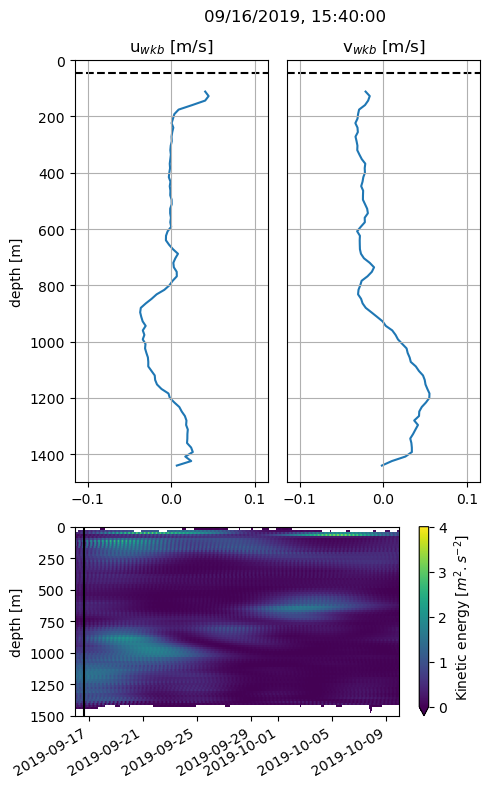

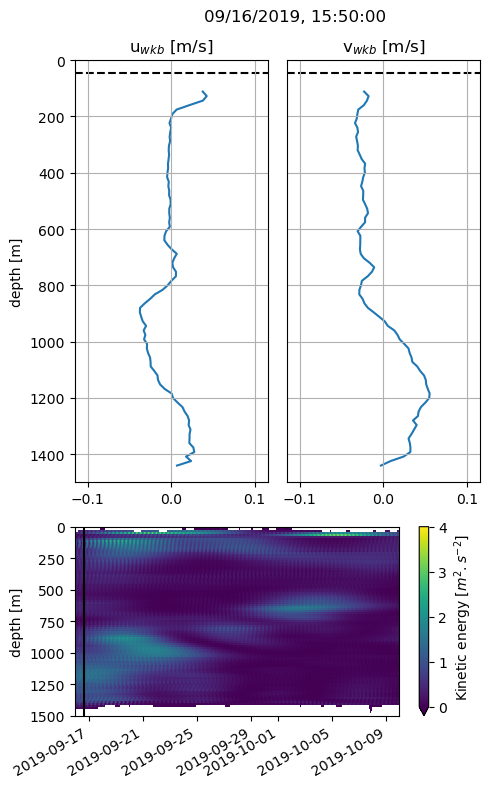

In [356]:
for i,t in enumerate(_time[100:102]):
    fig = plt.figure(tight_layout=True,figsize=(5,8))
    gs = gridspec.GridSpec(3,2)
    ax0 = fig.add_subplot(gs[2,:])
    ax0.axvline(t.values,c='k',zorder=1)
    ds['bp_eke'].sel(time=slice(ti,tf)).plot(ax=ax0,yincrease=False,vmax=4,vmin=0,cmap='viridis',zorder=-1);
    ax0.set_ylim(1500,0)
    ax0.set_title('');#ax0.set_xlabel('time');ax0.set_ylabel('Wind work')
    #ax0.tick_params(bottom=False,labelbottom=False)
    #fig,ax = plt.subplots(1,2,figsize=(10,5))
    for j,v in enumerate(['bpu_wkb','bpv_wkb']):
        ax = fig.add_subplot(gs[:2,j])
        ds.sel(time=t,z=slice(100,None))[v].plot(ax=ax,y='z',yincrease=False,zorder=1,
                                                      xlim=(ds.bpu_wkb.min(),ds.bpu_wkb.max()),ylim=(1500,0))
    #ds_filt.sel(time=t,z=slice(100,None)).bpv_wkb.plot(ax=ax[1],y='z',yincrease=False,zorder=1);
        #ax.axhline(mld_m1_argo.da_m1.sel(month=months[index]),ls='--',lw=1.5,c='k',zorder=-1)
        ax.axhline(ds['mld'].sel(time=t, method='nearest'),ls='--',lw=1.5,c='k',zorder=-1)
        #.plot(ax=ax,x='time',c='k',zorder=-1) 
        ax.grid();ax.set_title('');ax.set_xlabel('');ax.set_title(v[2]+r'$_{wkb}$ [m/s]')
    ax.tick_params(left=False,labelleft=False);ax.set_ylabel('');
    fig.suptitle(datetime.utcfromtimestamp(t.values.astype(int) * 1e-9).strftime('%m/%d/%Y, %H:%M:%S'),x=0.6)
    #plt.show();
    #fig.savefig(root_dir+'Figures/KE_event%s_time%s.png'%(index,i+8322));
    #fig.clear()
    #plt.close(fig)

### Low-frequency

In [14]:
ds_low = xr.open_dataset(root_dir+'data/M1_lpfiltered.nc').interpolate_na(dim='time',method='cubic',max_gap=pd.Timedelta(3, "d"))

In [44]:
index=2
ti,tf = t_start[index],t_end[index]


In [45]:
print(t_start[index],t_end[index])
#ti='2019-09-10T23:00:000'

<xarray.DataArray 'time' ()>
array('2019-12-13T16:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-12-13T16:00:00
    lat      float64 59.1
    lon      float64 -21.2
    mode     int64 1
Attributes:
    long_name:    <xarray.DataArray 'time' ()>
array('2020-01-24T19:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-02-12T11:00:00
    lat      float64 59.1
    lon      float64 -21.2
    mode     int64 1
Attributes:
    long_name:   


In [46]:
_time = ds.sel(time=slice(ti,tf)).time
_time

<xarray.DataArray 'time' (time: 6067)>
array(['2019-12-13T16:00:00.000000000', '2019-12-13T16:10:00.000000000',
       '2019-12-13T16:20:00.000000000', ..., '2020-01-24T18:40:00.000000000',
       '2020-01-24T18:50:00.000000000', '2020-01-24T19:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-12-13T16:00:00 ... 2020-01-24T19:00:00
    lat      float64 ...
    lon      float64 ...
    mode     int64 ...
Attributes:
    long_name:

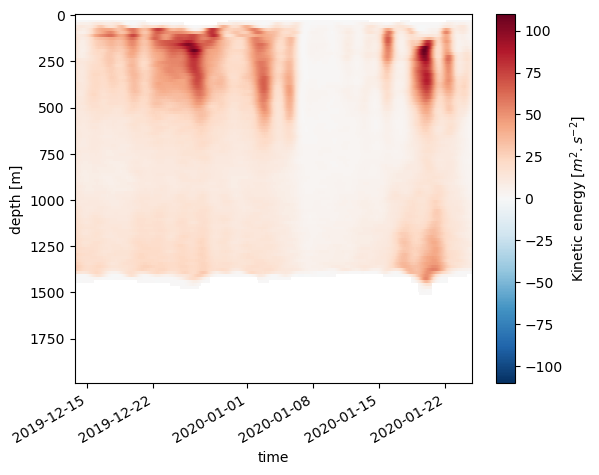

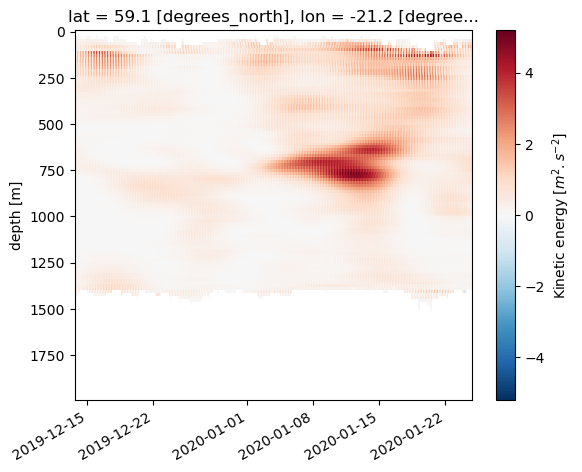

In [55]:
ds_low.bp_eke.sel(time=slice(ti,tf)).plot(yincrease=False)
plt.figure()
ds.bp_eke.sel(time=slice(ti,tf)).plot(yincrease=False)

KeyboardInterrupt: 

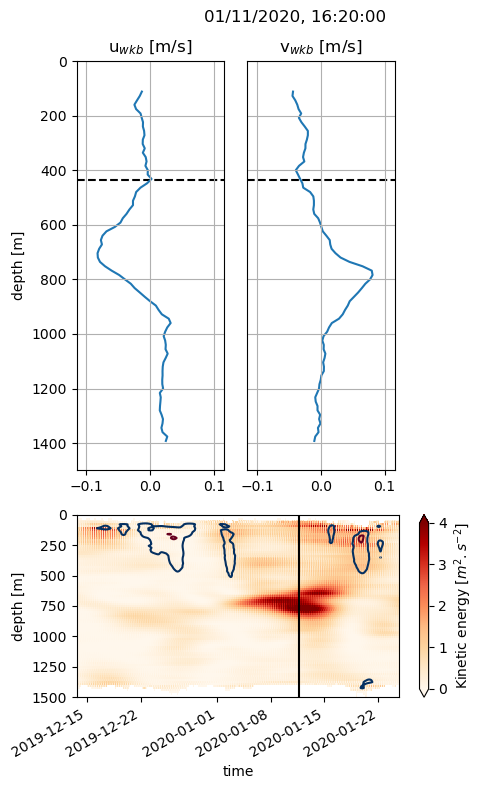

In [57]:
for i,t in enumerate(_time[:]):
    fig = plt.figure(tight_layout=True,figsize=(5,8))
    gs = gridspec.GridSpec(3,5)
    ax0 = fig.add_subplot(gs[2,:])
    ax0.axvline(t.values,c='k',zorder=1)
    
    ds['bp_eke'].sel(time=slice(ti,tf)).plot(ax=ax0,yincrease=False,vmax=4,vmin=0,cmap='OrRd',zorder=-1);
    ds_low['bp_eke'].sel(time=slice(ti,tf)).plot.contour(ax=ax0,yincrease=False,zorder=0,levels=[50,100]);
    ax0.set_ylim(1500,0)
    ax0.set_title('');#ax0.set_xlabel('time');ax0.set_ylabel('Wind work')
    #ax0.tick_params(bottom=False,labelbottom=False)
    #fig,ax = plt.subplots(1,2,figsize=(10,5))
    for j,v in zip([0,2],['bpu_wkb','bpv_wkb']):
        ax = fig.add_subplot(gs[:2,j:j+2])
        ds.sel(time=t,z=slice(100,None))[v].plot(ax=ax,y='z',yincrease=False,zorder=1,
                                                      xlim=(ds.bpu_wkb.min(),ds.bpu_wkb.max()),ylim=(1500,0))
    #ds_filt.sel(time=t,z=slice(100,None)).bpv_wkb.plot(ax=ax[1],y='z',yincrease=False,zorder=1);
        #ax.axhline(mld_m1_argo.da_m1.sel(month=months[index]),ls='--',lw=1.5,c='k',zorder=-1)
        ax.axhline(ds['mld'].sel(time=t, method='nearest'),ls='--',lw=1.5,c='k',zorder=-1)
        #.plot(ax=ax,x='time',c='k',zorder=-1) 
        ax.grid();ax.set_title('');ax.set_xlabel('');ax.set_title(v[2]+r'$_{wkb}$ [m/s]')
    ax.tick_params(left=False,labelleft=False);ax.set_ylabel('');
    fig.suptitle(datetime.utcfromtimestamp(t.values.astype(int) * 1e-9).strftime('%m/%d/%Y, %H:%M:%S'),x=0.6)
    #plt.show();
    fig.savefig(root_dir+'Figures/low_event%s_time%s.png'%(index,i));
    fig.clear()
    plt.close(fig)